In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-requisite: create a graph and a signal

For the graph we generate a dummy one randomly.

In [67]:
n = 100
W=np.random.randint(2, size=(n,n))  # random graph
W = W*W.T # make symetric
W[range(n), range(n)]=0 # remove diag
print("Weight matrix\n", W)

L = np.diag(sum(W)) - W
print("\nLaplacien (unnormalized)\n", L)

Weight matrix
 [[0 0 1 ..., 1 1 0]
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [1 0 0 ..., 0 0 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 1 0 0]]

Laplacien (unnormalized)
 [[40  0 -1 ..., -1 -1  0]
 [ 0 21  0 ...,  0  0  0]
 [-1  0 32 ...,  0  0  0]
 ..., 
 [-1  0  0 ..., 23  0 -1]
 [-1  0  0 ...,  0 26  0]
 [ 0  0  0 ..., -1  0 26]]


In [68]:
# generate a signal to put on the graph
x = np.sin(2 * np.pi * np.linspace(0, 1, n)) + np.random.normal(0, 0.1, n)

# Spectral Filter using numpy

Small function to implement the graph spectral filter as detailled in the pseudo-code of the sharelatex

In [69]:
def fast_filter(x, theta, L):
    ''' Fast localized spectral filter
    INPUT
        x: input signal in R^d
        theta: filter parameters in R^K
        L: Graph laplacian in R^{d*d}
    OUTPUT
        filtered signal y in R^d
    '''
    lambda_max = max(np.linalg.eig(L)[0]) # maximum eigenvalue
    K = theta.size
    L_tilde = 2*L/lambda_max - np.eye(L.shape[0])
    
    X = np.zeros((x.size, K)) # matrix to store all x_bar's
    X[:, 0] = x
    X[:, 1] = np.matmul(L_tilde, x)
    # compute tchebitchev recursion
    for k in range(2, K):
        X[:, k] = 2 * np.matmul(L_tilde, X[:, k-1]) - X[:, k-2]
    # return filtered signal
    return np.matmul(X, theta)

Now we apply the filter (with some theta) to the signal $x$

In [70]:
theta = np.random.rand(6)  # chose some filter parameters at random
print("theta", theta)

theta [ 0.61704449  0.04132445  0.52909269  0.15416698  0.72307897  0.80088248]


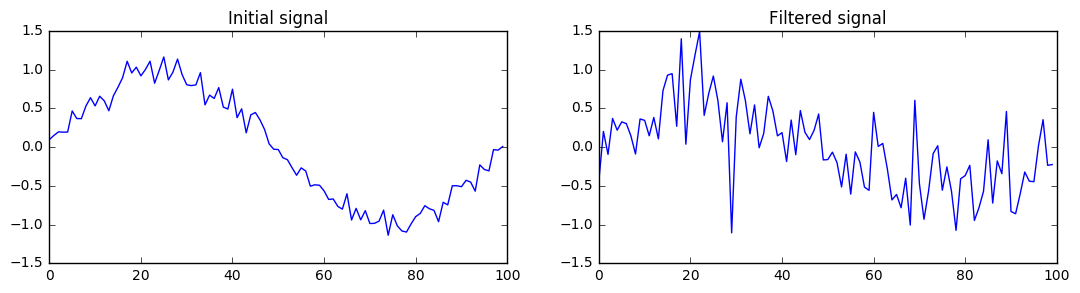

In [71]:
fig = plt.figure(figsize=(13, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

ax1.plot(x)
ax1.set_title("Initial signal")

ax2.plot(fast_filter(x, theta, L))
ax2.set_title("Filtered signal")

plt.show()

# Spectral filter in tensorflow

In [72]:
import tensorflow as tf
tf.reset_default_graph()

We first build the filter with symbolic variables

In [73]:
K = 6  # number of filter parameters
theta_tf = tf.Variable(np.array(np.random.uniform(-1, 1, size=(K,1)), dtype=np.float32))
X_tf = tf.placeholder(tf.float32, [None, K])
y_tf = tf.matmul(X_tf, theta_tf)

In [74]:
# function to get the matrix with all chebitchev
def return_X(x, K, L):
    ''' Fast localized spectral filter
    INPUT
        x: input signal in R^d
        K: number of filter parameters
        L: Graph laplacian in R^{d*d}
    OUTPUT
        W matrix with all the chebtichev vectors \bar x_k as columns
    '''
    lambda_max = max(np.linalg.eig(L)[0]) # maximum eigenvalue
    L_tilde = 2*L/lambda_max - np.eye(L.shape[0])
    
    X = np.zeros((x.size, K)) # matrix to store all x_bar's
    X[:, 0] = x
    X[:, 1] = np.matmul(L_tilde, x)
    # compute tchebitchev recursion
    for k in range(2, K):
        X[:, k] = 2 * np.matmul(L_tilde, X[:, k-1]) - X[:, k-2]
    # return tchebitchev
    return X

We now generate the $\bar X$ matrix

In [75]:
X_bar = return_X(x, K, L)

Launch a tensorflow session to retrieve the filtered signal

In [76]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

y_tf_result = sess.run(y_tf, feed_dict={
        X_tf: X_bar, 
        theta_tf: theta.reshape((-1,1))
    })

Plot the results...

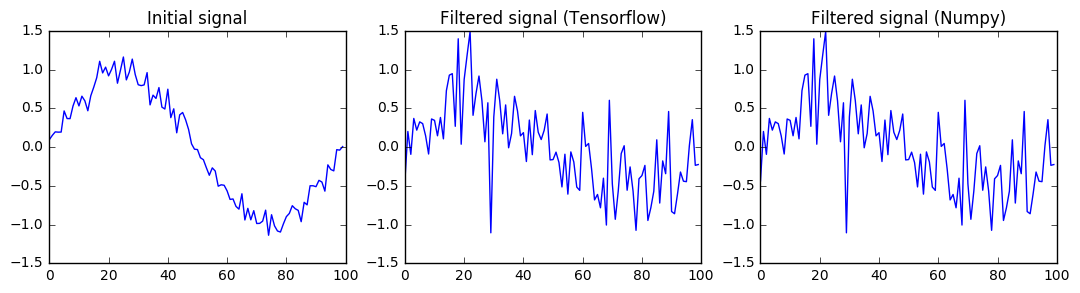

In [77]:
fig = plt.figure(figsize=(13, 3))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

ax1.plot(x)
ax1.set_title("Initial signal")

ax2.plot(y_tf_result)
ax2.set_title("Filtered signal (Tensorflow)")

ax3.plot(fast_filter(x, theta, L))
ax3.set_title("Filtered signal (Numpy)")

plt.show()

We see that the two filters (numpy and tensorflow) give the same results! Fortunately!

# What if we want to learn a filter using Gradient Descent?

To illustrate we will try to learn the inverse filter, that allows to get back to the initial filter from the filtered signal.

We add two tensorflow variables for the target signal and a loss for the gradient descent

In [78]:
y_target = tf.placeholder(tf.float32, [None, 1])
loss_tf = tf.reduce_sum((y_tf - y_target)**2)  # squared differences as loss

We can first see how bad it is before optimizing $\theta$, that is with a random $\theta$

In [79]:
init = tf.global_variables_initializer()  # will reset theta
sess = tf.Session()
sess.run(init)

[y_tf_result, loss] = sess.run([y_tf, loss_tf], feed_dict={
        X_tf: X_bar, 
         y_target: x.reshape((-1,1))  # the target is the original signal to inverse the filter!
    })

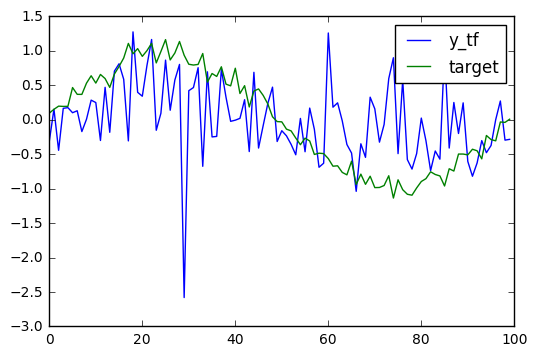

In [80]:
plt.plot(y_tf_result)
plt.plot(x)
plt.legend(["y_tf", "target"])
plt.show()

We see with the plot that the filtered version is not the same at all than the one we computed using numpy and our fast_filter function. This is totally normal since we initialized our theta_tf at random! We can quantify the difference with the loss:

In [81]:
print("loss before optimizing:", loss)

loss before optimizing: 55.9054


What we will try now is to optimize the theta_tf using Gradient descend to get the original signal back i.e. inverse the filter. Be careful, the gradient descent is really sensitive to the learning rate and may diverge if it is too large.

In [82]:
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss_tf, var_list=[theta_tf])

In [83]:
# do 1000 iteration of the GD
for i in range(1001):
    [current_loss, _] = sess.run([loss_tf, train_step], feed_dict={
            X_tf: X_bar,
            y_target: x.reshape((-1,1))
        })
    if i%100==0:
        print("{}\tloss: {}".format(i,current_loss,2))

0	loss: 55.90540313720703
100	loss: 0.1631641834974289
200	loss: 0.07001180946826935
300	loss: 0.05195208266377449
400	loss: 0.038703545928001404
500	loss: 0.028917063027620316
600	loss: 0.021687017753720284
700	loss: 0.016345040872693062
800	loss: 0.012397414073348045
900	loss: 0.009479617699980736
1000	loss: 0.007322488818317652


We can finally retrieve our filtered signal and plot it with our initial filtered signal:

In [84]:
y_tf_result = sess.run(y_tf, feed_dict={
        X_tf: X_bar,
        y_target: x.reshape((-1,1))
    })

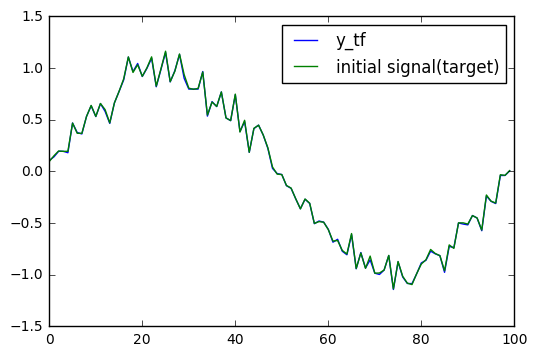

In [85]:
plt.plot(y_tf_result)
plt.plot(x)
plt.legend(["y_tf", "initial signal(target)"])
plt.show()

We see that the filter learnt well, we are quite close to the original filter

We can also look at the $\theta$ that was learnt:

In [86]:
theta_learnt = sess.run([theta_tf], feed_dict={X_tf: X_bar})[0].reshape((-1))
print("theta learnt", theta_learnt)

theta learnt [ 0.76752645  0.37272039 -0.3568047   0.21791692 -0.13543536  0.05041281]
